In [30]:
# -*- coding: utf-8 -*-
import urllib.request, time, re, random, hashlib
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine, euclidean
from itertools import combinations
from scipy.cluster import hierarchy
%matplotlib inline

In [31]:
# IMPORTANT:  PLEASE USE THE FOLLOWING fetch(url) TO LOAD ALL YOUR 
# WEBPAGES. PLEASE DO NOT DIRECTLY LOAD PAGES. THIS WILL ENSURE THAT
# PAGES ARE CACHED AS FILES IN YOUR DIRECTORY, AND AVOID UNNECESSARY
# LOAD ON WEBSITES.  ALSO WHEN PAGES ARE ACTUALLY LOADED, THE REQUESTS
# ARE STAGGERED AS EXPECTED OF HUMAN BROWSING.

# Compassionate Caching inspired by 
# http://lethain.com/an-introduction-to-compassionate-screenscraping/

last_fetched_at = None

def fetch(url):
    """Load the url compassionately."""
    
    global last_fetched_at
    
    url_hash = hashlib.sha1(url.encode()).hexdigest()
    filename = 'cache-file-{}'.format(url_hash)
    try:
        with open(filename, 'r') as f:
            result = f.read()
            if len(result) > 0:
                print("Retrieving from cache:", url)
                return result
    except:
        pass
    
    print("Loading:", url)
    wait_interval = random.randint(3000,10000)
    if last_fetched_at is not None:
        now = time.time()
        elapsed = now - last_fetched_at
        if elapsed < wait_interval:
            time.sleep((wait_interval - elapsed)/1000)
        
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
    headers = { 'User-Agent' : user_agent }
    req = urllib.request.Request(url, headers = headers)
    last_fetched_at = time.time()
    with urllib.request.urlopen(req) as response:
        result = str(response.read())
        with open(filename, 'w') as f:
            f.write(result)
        return result

In [32]:
class Entity(object):
    def __init__(self, name):
        self.name = name
        self.words = None
        self.vector = None

In [33]:
def get_search_results(entity):
    """Return an html with search results for given entity."""
    url = 'http://www.usatoday.com/search/'+entity.name.replace(' ', '+')+'/1/'
    result = fetch(url)
    
    return result

In [34]:
from bs4 import BeautifulSoup as bs
def get_articles(results_html, n=3):
    """Return a list of article htmls for given search results html."""
    soup = bs(results_html, 'lxml', from_encoding='utf-8')
    url_list =[]
    res = soup.find_all('li', class_="text search-result-item")
    for news in res:
        link = news.find('a').get('href')

        #Resutls sometimes have relative paths and sometimes don't
        if link[0]=='/':
            url = 'http://www.usatoday.com'+link
        else:
            url = link
        url_list.append(url)
   
    articles_html = []
    for url in url_list[:n]:
        result = fetch(url)
        articles_soup = bs(result, 'lxml', from_encoding='utf-8')
        articles_html.append(articles_soup)
    return articles_html

In [35]:
from nltk.corpus import stopwords
from nltk import word_tokenize, wordpunct_tokenize, FreqDist
from nltk.tokenize import RegexpTokenizer


def get_words(articles):
    """Return list of representative words from a list of article 
    htmls."""
    
    words = []
    tokenizer = RegexpTokenizer(r'\w+')  # Removes punctuation
    
    for a in articles:
        pre_text = a.find_all('p', attrs={'class':None})
        for p in pre_text[1:-1]: #The last one is the twitter one. The first one is garbage
            #Ugly looking hack
            word_list = tokenizer.tokenize(p.get_text().replace("\xc2\xa0", " ").replace("xc2", "").replace("xa0", ""))
            for w in word_list:
                if w not in stopwords.words('english') and w.isalpha():
                    words.append(w.lower())
    fdist = FreqDist(words)
    mc = [w for (w, n) in fdist.most_common(50)] #The 50 most common words
    return mc

In [36]:
def get_bag_of_words(entity):
    results = get_search_results(entity)
    articles = get_articles(results,3)
    return get_words(articles)

In [37]:
def get_bow_vectors(list_of_texts):
    """Return feature vectors for each entity given list of texts."""
    vectorizer = CountVectorizer(analyzer = "word",
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 max_features = 500)
    compressed_vectors = vectorizer.fit_transform(list_of_texts)
    return compressed_vectors.toarray()

In [38]:
def cluster_candidates(politicians):

    entities = [Entity(p) for p in politicians]

    texts = []
    for e in entities:
        e.words = get_bag_of_words(e)
        texts.append(" ".join(e.words))

    vectors = get_bow_vectors(texts)

    for i, e in enumerate(entities):
        e.vector = vectors[i]

    distances = []
    for e, f in combinations(entities, 2):
        distance = euclidean(e.vector, f.vector)

        print(e.name, f.name, distance)
        distances.append(distance)

    _ = hierarchy.dendrogram(hierarchy.linkage(distances), 
                         labels = [e.name for e in entities])

Retrieving from cache: http://www.usatoday.com/search/hillary+clinton/1/
Retrieving from cache: http://www.usatoday.com/story/news/politics/2013/11/26/hillary-clinton-2016-president-democratic-nomination/2063287/
Retrieving from cache: http://www.usatoday.com/story/news/politics/onpolitics/2016/01/15/hillary-clinton-defends-donald-trump/78848730/
Retrieving from cache: http://www.usatoday.com/story/news/politics/onpolitics/2016/01/15/hillary-clinton-dismisses-joe-biden-remarks/78846684/
Retrieving from cache: http://www.usatoday.com/search/donald+trump/1/
Retrieving from cache: http://www.usatoday.com/story/news/politics/onpolitics/2016/01/15/hillary-clinton-defends-donald-trump/78848730/
Retrieving from cache: http://www.usatoday.com/story/news/politics/onpolitics/2016/01/15/republican-debate-donald-trump-ted-cruz-fox-business-network/78837200/
Retrieving from cache: http://www.usatoday.com/story/news/politics/onpolitics/2016/01/15/presidential-debates-ranked-viewership/78867956/
Retr

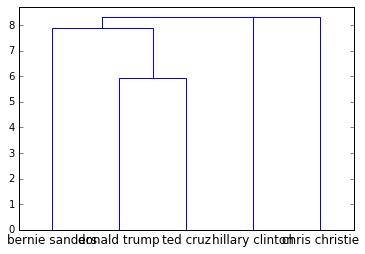

In [39]:
cluster_candidates(['hillary clinton', 'donald trump',
                    'ted cruz', 'bernie sanders', 'chris christie'])